# Initialization

In [1]:
%load_ext autoreload
%autoreload 2
import sys, warnings, time, numpy, yaml, pandas, logging, random
from pathlib import Path
sys.path.append("../src/") # go to parent dir
from data_access import get_X, get_y, get_train_test
from models.factory import ModelFactory
warnings.filterwarnings('ignore')
with open('../confs/logs.yaml', 'rt') as f:
    config = yaml.safe_load(f.read())
logging.config.dictConfig(config)

In [2]:
type='team'
X_train, y_train, X_test, y_test, target = get_train_test(train_size=0.8, random_state=42)
train_scores = get_y('train', type)
test_data = get_X('test', type)

In [3]:
def eval_model(model, save_model=False, X=X_test):
    start = time.time()
    model.fit()
    score = model.evaluate(X)
    end = time.time()
    logging.debug(f'{model.name}={score} in {numpy.round((end-start), 2)}s')
    if save_model:
        model.save(test_data)
    return {'name': model.name, 'score': score, 'time': numpy.round((end-start), 2)}

In [4]:
%load_ext autoreload
%autoreload 2
def eval_model_for_name(name, X=X_train, y=y_train):
    with open('../confs/models.yaml', 'r') as file:
        configurations = yaml.safe_load(file)
    factory = ModelFactory(configurations, X, y, train_scores)
    model = factory.get_model(name)
    return eval_model(model)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_features(name = 'ada_boost'):
    with open('../confs/models.yaml', 'r') as file:
        configurations = yaml.safe_load(file)
    factory = ModelFactory(configurations, X_train, y_train, train_scores)
    model = factory.get_model(name)
    eval_model(model)
    df_importances = model.get_feature_importances()
    return list(df_importances['feature'])

In [6]:
default_features=get_features('ada_boost')
default_features=['TEAM_PASSES_season_sum', 'TEAM_DANGEROUS_ATTACKS_season_std', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_GAME_WON_season_sum', 'TEAM_INJURIES_5_last_match_sum', 'TEAM_DANGEROUS_ATTACKS_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_std', 'TEAM_GAME_LOST_season_sum']
default_features=['TEAM_GAME_WON_season_sum', 'TEAM_GAME_LOST_season_sum', 'TEAM_GAME_WON_season_average', 'TEAM_GAME_LOST_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_SHOTS_ON_TARGET_season_sum', 'TEAM_GOALS_season_sum', 'TEAM_GOALS_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_season_average', 'TEAM_PASSES_season_sum', 'TEAM_SHOTS_ON_TARGET_season_average', 'TEAM_SHOTS_ON_TARGET_5_last_match_average', 'TEAM_SHOTS_TOTAL_season_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'TEAM_BALL_POSSESSION_5_last_match_average', 'TEAM_SHOTS_ON_TARGET_5_last_match_sum', 'TEAM_PASSES_season_average', 'TEAM_GAME_LOST_5_last_match_sum', 'TEAM_GAME_WON_5_last_match_sum', 'TEAM_CORNERS_5_last_match_average', 'TEAM_CORNERS_season_sum', 'TEAM_CORNERS_season_average', 'TEAM_SHOTS_TOTAL_5_last_match_sum', 'TEAM_GOALS_5_last_match_average', 'TEAM_CORNERS_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_season_sum', 'TEAM_SUCCESSFUL_PASSES_5_last_match_sum', 'TEAM_GOALS_5_last_match_sum', 'TEAM_GAME_WON_5_last_match_average', 'TEAM_PASSES_5_last_match_sum', 'TEAM_SHOTS_TOTAL_5_last_match_average', 'TEAM_PASSES_5_last_match_average', 'TEAM_DANGEROUS_ATTACKS_5_last_match_average', 'TEAM_DANGEROUS_ATTACKS_season_average', 'TEAM_GAME_LOST_5_last_match_average', 'TEAM_SHOTS_OFF_TARGET_season_average', 'TEAM_SHOTS_OFF_TARGET_season_sum', 'TEAM_ATTACKS_season_average', 'TEAM_SAVES_season_average', 'TEAM_GOALS_season_std', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_5_last_match_average', 'TEAM_SAVES_season_sum', 'TEAM_SHOTS_OFF_TARGET_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_ATTACKS_season_sum', 'TEAM_DANGEROUS_ATTACKS_season_sum', 'TEAM_DANGEROUS_ATTACKS_5_last_match_sum', 'TEAM_SHOTS_TOTAL_season_std', 'TEAM_SHOTS_ON_TARGET_season_std', 'TEAM_CORNERS_season_std', 'TEAM_SHOTS_OUTSIDEBOX_season_average', 'TEAM_ATTACKS_5_last_match_sum', 'TEAM_SHOTS_OFF_TARGET_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_std', 'TEAM_ATTACKS_5_last_match_average', 'TEAM_SHOTS_OUTSIDEBOX_season_std', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_average', 'TEAM_DANGEROUS_ATTACKS_season_std', 'TEAM_SAVES_season_std', 'TEAM_REDCARDS_season_sum', 'TEAM_SHOTS_OFF_TARGET_season_std', 'TEAM_SHOTS_INSIDEBOX_season_std', 'TEAM_PASSES_season_std', 'TEAM_SHOTS_INSIDEBOX_5_last_match_std', 'TEAM_SAVES_5_last_match_average', 'TEAM_SHOTS_OUTSIDEBOX_season_sum', 'TEAM_GOALS_5_last_match_std', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum', 'TEAM_YELLOWCARDS_5_last_match_sum', 'TEAM_YELLOWCARDS_season_sum', 'TEAM_FOULS_5_last_match_average', 'TEAM_OFFSIDES_5_last_match_sum', 'TEAM_SUBSTITUTIONS_season_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_std', 'TEAM_SAVES_5_last_match_std', 'TEAM_FOULS_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_5_last_match_std', 'TEAM_OFFSIDES_5_last_match_average', 'TEAM_SHOTS_OFF_TARGET_5_last_match_std', 'TEAM_GAME_DRAW_season_average', 'TEAM_ATTACKS_season_std', 'TEAM_BALL_POSSESSION_5_last_match_std', 'TEAM_REDCARDS_5_last_match_sum', 'TEAM_SUBSTITUTIONS_season_sum', 'TEAM_PENALTIES_5_last_match_std', 'TEAM_REDCARDS_season_average', 'TEAM_BALL_POSSESSION_season_std', 'TEAM_BALL_SAFE_season_average', 'TEAM_DANGEROUS_ATTACKS_5_last_match_std', 'TEAM_FOULS_season_std', 'TEAM_GAME_DRAW_5_last_match_sum', 'TEAM_INJURIES_5_last_match_sum', 'TEAM_INJURIES_season_sum', 'TEAM_OFFSIDES_5_last_match_std', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_std', 'TEAM_REDCARDS_5_last_match_average', 'TEAM_INJURIES_5_last_match_average', 'TEAM_BALL_SAFE_5_last_match_std', 'TEAM_SUBSTITUTIONS_season_std', 'TEAM_PENALTIES_season_average', 'TEAM_FOULS_season_average', 'TEAM_SHOTS_ON_TARGET_5_last_match_std', 'TEAM_BALL_SAFE_5_last_match_sum', 'TEAM_BALL_SAFE_5_last_match_average', 'TEAM_PENALTIES_season_sum', 'TEAM_REDCARDS_5_last_match_std', 'TEAM_FOULS_season_sum', 'TEAM_SHOTS_TOTAL_5_last_match_std', 'TEAM_YELLOWCARDS_season_average', 'TEAM_REDCARDS_season_std', 'TEAM_FOULS_5_last_match_std', 'TEAM_BALL_SAFE_season_sum', 'TEAM_OFFSIDES_season_sum', 'TEAM_SUBSTITUTIONS_5_last_match_std', 'TEAM_PASSES_5_last_match_std', 'TEAM_YELLOWCARDS_5_last_match_average', 'TEAM_YELLOWCARDS_season_std', 'TEAM_PENALTIES_5_last_match_average', 'TEAM_PENALTIES_season_std', 'TEAM_BALL_SAFE_season_std', 'TEAM_SUBSTITUTIONS_5_last_match_sum', 'TEAM_INJURIES_season_std', 'TEAM_YELLOWCARDS_5_last_match_std', 'TEAM_PENALTIES_5_last_match_sum', 'TEAM_INJURIES_5_last_match_std', 'TEAM_INJURIES_season_average', 'TEAM_ATTACKS_5_last_match_std', 'TEAM_SAVES_5_last_match_sum', 'TEAM_GAME_DRAW_5_last_match_average', 'TEAM_OFFSIDES_season_std', 'TEAM_SUBSTITUTIONS_5_last_match_average', 'TEAM_OFFSIDES_season_average', 'TEAM_CORNERS_5_last_match_std', 'TEAM_GAME_DRAW_season_sum']

In [7]:
def test_features(name = 'xgb_gblinear', save=True, features=default_features):
    with open('../confs/models.yaml', 'r') as file:
        configurations = yaml.safe_load(file)
    if features is None:
        features=default_features
    lines = []
    best_score = 0
    selected_features = []
    for i in range(1, len(features)):
        sub_features = selected_features.copy()
        feature = features[i-1]
        sub_features.append(feature)
        # sub_features = features[:i]
        factory = ModelFactory(configurations, X_train[sub_features], y_train, train_scores)
        model = factory.get_model(name)
        model.name = f'{name}_{i}'
        line = eval_model(model,X=X_test[sub_features])
        line['nbr_features'] = len(sub_features)
        line['model'] = name
        line['feature'] = feature
        line['features'] = sub_features
        lines.append(line)
        if best_score < line['score']:
            selected_features.append(line['feature'])
            best_score = line['score']
    df = pandas.DataFrame(lines)
    if save:
        df.to_csv(f'../data/output/features/{name}.csv')
    logging.info(f'Features selected for score {name} - {best_score}: {len(selected_features)}, {selected_features}')
    return df

In [8]:
def plot_features(folder = '../data/output/features/'):
   import os, pandas
   df = None
   for filename in os.listdir(folder):
      # if not os.path.isfile(filename): continue
      model = filename.split('.')[0]
      df_tmp = pandas.read_csv(f'{folder}{filename}')
      df_tmp[model] = df_tmp['score']
      if df is None:
         df = df_tmp[[model]]
      else:
         df[model] = df_tmp[[model]]
   df.plot.line()

# Feature importances

In [9]:
# names= ['random_forest', 'lightgbm', 'xgb_gblinear']
# # for name in names:
# #     logging.info(f'{name}: {get_features(name)}')
# features = get_features(name = 'random_forest')
# # features=['TEAM_GAME_WON_season_average', 'TEAM_GAME_LOST_season_average', 'TEAM_GOALS_season_sum', 'TEAM_GAME_LOST_season_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_CORNERS_season_sum', 'TEAM_DANGEROUS_ATTACKS_season_average', 'TEAM_BALL_POSSESSION_5_last_match_average', 'TEAM_ATTACKS_5_last_match_std', 'TEAM_YELLOWCARDS_5_last_match_std', 'TEAM_CORNERS_5_last_match_average', 'TEAM_BALL_POSSESSION_5_last_match_std', 'TEAM_SHOTS_ON_TARGET_5_last_match_std', 'TEAM_FOULS_season_std', 'TEAM_BALL_SAFE_season_average', 'TEAM_FOULS_5_last_match_std', 'TEAM_ATTACKS_season_sum', 'TEAM_BALL_POSSESSION_season_std', 'TEAM_SHOTS_ON_TARGET_season_std', 'TEAM_BALL_SAFE_season_sum', 'TEAM_YELLOWCARDS_season_std', 'TEAM_OFFSIDES_5_last_match_std', 'TEAM_PENALTIES_season_std', 'TEAM_BALL_SAFE_5_last_match_sum', 'TEAM_SUBSTITUTIONS_season_average', 'TEAM_GOALS_5_last_match_std', 'TEAM_SHOTS_OFF_TARGET_season_average', 'TEAM_YELLOWCARDS_season_sum', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_std', 'TEAM_REDCARDS_season_average', 'TEAM_GAME_DRAW_season_average', 'TEAM_DANGEROUS_ATTACKS_5_last_match_sum', 'TEAM_OFFSIDES_5_last_match_average', 'TEAM_SHOTS_OFF_TARGET_5_last_match_sum', 'TEAM_FOULS_season_average', 'TEAM_SHOTS_OFF_TARGET_5_last_match_average', 'TEAM_SAVES_5_last_match_average', 'TEAM_GOALS_5_last_match_average', 'TEAM_INJURIES_season_average', 'TEAM_FOULS_5_last_match_sum', 'TEAM_INJURIES_season_sum', 'TEAM_PASSES_5_last_match_std', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_INJURIES_5_last_match_average', 'TEAM_REDCARDS_season_sum', 'TEAM_SUBSTITUTIONS_5_last_match_std', 'TEAM_INJURIES_season_std', 'TEAM_SUCCESSFUL_PASSES_5_last_match_std', 'TEAM_GAME_DRAW_5_last_match_sum', 'TEAM_SHOTS_TOTAL_5_last_match_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_average', 'TEAM_SHOTS_OUTSIDEBOX_season_sum', 'TEAM_GAME_LOST_5_last_match_sum', 'TEAM_PENALTIES_5_last_match_std', 'TEAM_SHOTS_TOTAL_5_last_match_sum', 'TEAM_PENALTIES_5_last_match_average', 'TEAM_REDCARDS_5_last_match_std', 'TEAM_PASSES_5_last_match_sum']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_GAME_LOST_season_average', 'TEAM_GOALS_season_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_CORNERS_season_sum', 'TEAM_DANGEROUS_ATTACKS_season_average', 'TEAM_YELLOWCARDS_5_last_match_std', 'TEAM_CORNERS_5_last_match_average', 'TEAM_BALL_POSSESSION_5_last_match_std', 'TEAM_SHOTS_ON_TARGET_5_last_match_std', 'TEAM_FOULS_season_std', 'TEAM_BALL_SAFE_season_average', 'TEAM_SHOTS_ON_TARGET_season_std', 'TEAM_YELLOWCARDS_season_std', 'TEAM_BALL_SAFE_5_last_match_sum', 'TEAM_SHOTS_OFF_TARGET_season_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_std', 'TEAM_GAME_DRAW_season_average', 'TEAM_DANGEROUS_ATTACKS_5_last_match_sum', 'TEAM_OFFSIDES_5_last_match_average', 'TEAM_SHOTS_OFF_TARGET_5_last_match_sum', 'TEAM_FOULS_season_average', 'TEAM_GOALS_5_last_match_average', 'TEAM_INJURIES_season_sum', 'TEAM_PASSES_5_last_match_std', 'TEAM_REDCARDS_season_sum', 'TEAM_SHOTS_OUTSIDEBOX_season_sum', 'TEAM_GAME_LOST_5_last_match_sum', 'TEAM_PENALTIES_5_last_match_average', 'TEAM_REDCARDS_5_last_match_std']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_GAME_LOST_season_average', 'TEAM_GOALS_season_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_DANGEROUS_ATTACKS_season_average', 'TEAM_CORNERS_5_last_match_average', 'TEAM_FOULS_season_std', 'TEAM_BALL_SAFE_season_average', 'TEAM_SHOTS_ON_TARGET_season_std', 'TEAM_BALL_SAFE_5_last_match_sum', 'TEAM_GAME_DRAW_season_average', 'TEAM_DANGEROUS_ATTACKS_5_last_match_sum', 'TEAM_SHOTS_OFF_TARGET_5_last_match_sum', 'TEAM_FOULS_season_average', 'TEAM_PASSES_5_last_match_std', 'TEAM_REDCARDS_season_sum', 'TEAM_SHOTS_OUTSIDEBOX_season_sum']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_GAME_LOST_season_average', 'TEAM_GOALS_season_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_CORNERS_5_last_match_average', 'TEAM_FOULS_season_std', 'TEAM_BALL_SAFE_season_average', 'TEAM_BALL_SAFE_5_last_match_sum', 'TEAM_GAME_DRAW_season_average', 'TEAM_SHOTS_OFF_TARGET_5_last_match_sum', 'TEAM_FOULS_season_average']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_GAME_LOST_season_average', 'TEAM_GOALS_season_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_CORNERS_5_last_match_average', 'TEAM_BALL_SAFE_5_last_match_sum', 'TEAM_GAME_DRAW_season_average']

2024-02-23 19:07:23,333 - root- INFO - Features selected for score lightgbm - 0.4929: 11, ['TEAM_GAME_WON_season_sum', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_SHOTS_ON_TARGET_season_sum', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_ON_TARGET_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'TEAM_BALL_POSSESSION_5_last_match_average', 'TEAM_SHOTS_ON_TARGET_5_last_match_sum', 'TEAM_PASSES_5_last_match_average', 'TEAM_SHOTS_OFF_TARGET_season_average', 'TEAM_SHOTS_OFF_TARGET_season_sum']


<Axes: >

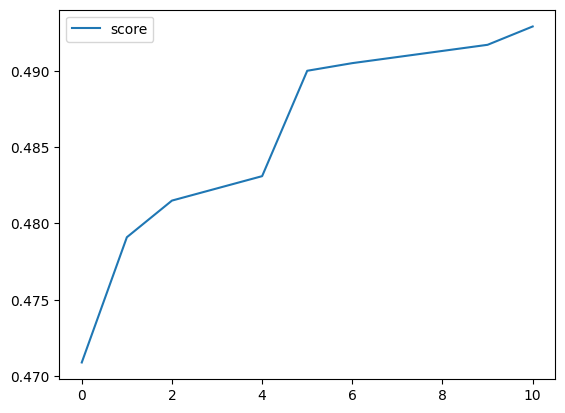

In [25]:
name = 'lightgbm'
features=None
features=['TEAM_GAME_WON_season_sum', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_SHOTS_ON_TARGET_season_sum', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_ON_TARGET_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'TEAM_BALL_POSSESSION_5_last_match_average', 'TEAM_SHOTS_ON_TARGET_5_last_match_sum', 'TEAM_PASSES_5_last_match_average', 'TEAM_SHOTS_OFF_TARGET_season_average', 'TEAM_SHOTS_OFF_TARGET_season_sum', 'TEAM_ATTACKS_season_average']
df = test_features(name, features=features)
df[['score']].plot.line()

2024-02-23 20:26:38,357 - root- INFO - Features selected for score ada_boost - 0.5095: 13, ['TEAM_GAME_WON_season_sum', 'TEAM_GAME_LOST_season_sum', 'TEAM_GAME_WON_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_GOALS_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_SHOTS_ON_TARGET_5_last_match_average', 'TEAM_SAVES_season_sum', 'TEAM_GOALS_5_last_match_std', 'TEAM_SAVES_5_last_match_std', 'TEAM_SUCCESSFUL_PASSES_5_last_match_std', 'TEAM_OFFSIDES_5_last_match_average']


<Axes: >

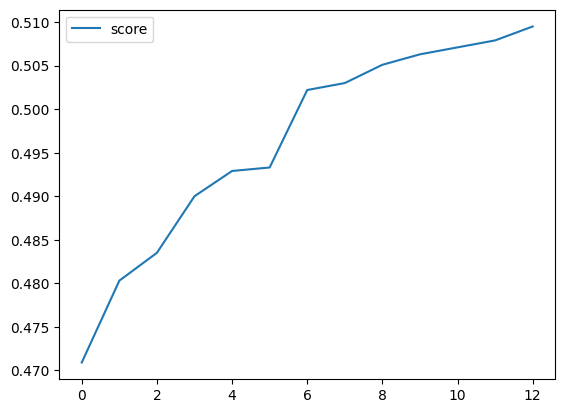

In [50]:
name = 'ada_boost'
features=None
features=['TEAM_GAME_WON_season_sum', 'TEAM_GAME_LOST_season_sum', 'TEAM_GAME_WON_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_GOALS_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_SHOTS_ON_TARGET_5_last_match_average', 'TEAM_SAVES_season_sum', 'TEAM_GOALS_5_last_match_std', 'TEAM_SAVES_5_last_match_std', 'TEAM_SUCCESSFUL_PASSES_5_last_match_std', 'TEAM_OFFSIDES_5_last_match_average', 'TEAM_SUBSTITUTIONS_5_last_match_average']
df = test_features(name, features=features)
df[['score']].plot.line()

2024-02-23 19:01:21,683 - root- INFO - Features selected for score xgb_gblinear - 0.5059: 10, ['TEAM_GAME_WON_season_sum', 'TEAM_GAME_LOST_season_sum', 'TEAM_GAME_WON_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_GOALS_season_sum', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_season_average', 'TEAM_SHOTS_ON_TARGET_season_average']


<Axes: >

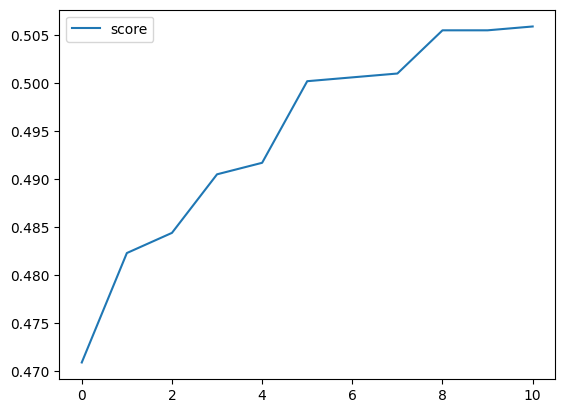

In [12]:
name = 'xgb_gblinear'
features=None
features=['TEAM_GAME_WON_season_sum', 'TEAM_GAME_LOST_season_sum', 'TEAM_GAME_WON_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_GOALS_season_sum', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_season_average', 'TEAM_PASSES_season_sum', 'TEAM_SHOTS_ON_TARGET_season_average', 'TEAM_SUCCESSFUL_PASSES_season_sum']
df = test_features(name, features=features)
df[['score']].plot.line()

2024-02-23 19:01:40,941 - root- INFO - Features selected for score gradient_boosting - 0.5022: 6, ['TEAM_GAME_WON_season_sum', 'TEAM_GAME_LOST_season_sum', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_GOALS_season_sum', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_average']


<Axes: >

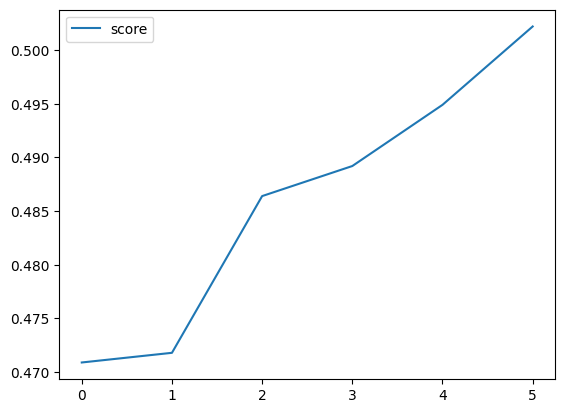

In [13]:
name = 'gradient_boosting'
features=None
features=['TEAM_GAME_WON_season_sum', 'TEAM_GAME_LOST_season_sum', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_GOALS_season_sum', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_SUCCESSFUL_PASSES_5_last_match_average']
df = test_features(name, features=features)
df[['score']].plot.line()

2024-02-23 19:02:04,344 - root- INFO - Features selected for score hist_gradient_boosting - 0.4888: 9, ['TEAM_GAME_WON_season_sum', 'TEAM_GAME_WON_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_PASSES_5_last_match_sum', 'TEAM_SHOTS_TOTAL_season_std', 'TEAM_ATTACKS_5_last_match_average', 'TEAM_SAVES_5_last_match_average', 'TEAM_SUBSTITUTIONS_season_sum']


<Axes: >

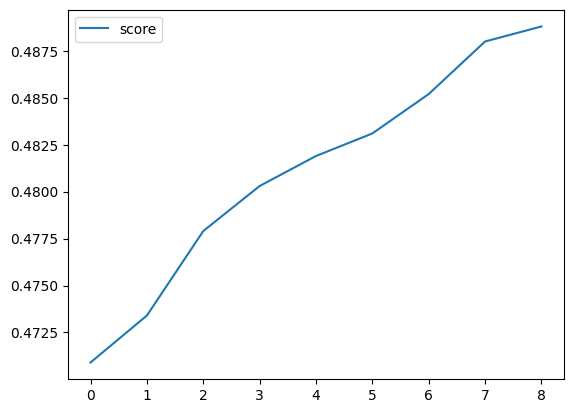

In [14]:
name = 'hist_gradient_boosting'
features=None
features=['TEAM_GAME_WON_season_sum', 'TEAM_GAME_WON_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_PASSES_5_last_match_sum', 'TEAM_SHOTS_TOTAL_season_std', 'TEAM_ATTACKS_5_last_match_average', 'TEAM_SAVES_5_last_match_average', 'TEAM_SUBSTITUTIONS_season_sum', 'TEAM_FOULS_5_last_match_std']
df = test_features(name, features=features)
df[['score']].plot.line()

2024-02-23 19:02:10,421 - root- INFO - Features selected for score xgb_classifier - 0.5035: 9, ['TEAM_GAME_WON_season_sum', 'TEAM_GAME_LOST_season_sum', 'TEAM_GAME_WON_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_average', 'TEAM_PASSES_season_sum', 'TEAM_SHOTS_TOTAL_season_average']


<Axes: >

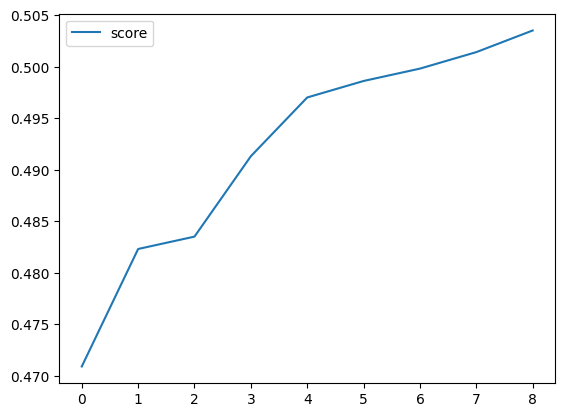

In [15]:
name = 'xgb_classifier'
features=None
features=['TEAM_GAME_WON_season_sum', 'TEAM_GAME_LOST_season_sum', 'TEAM_GAME_WON_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_average', 'TEAM_PASSES_season_sum', 'TEAM_SHOTS_TOTAL_season_average', 'TEAM_SUCCESSFUL_PASSES_season_sum', 'TEAM_SAVES_5_last_match_average', 'TEAM_YELLOWCARDS_5_last_match_sum', 'TEAM_PENALTIES_5_last_match_average', 'TEAM_SUBSTITUTIONS_5_last_match_sum', 'TEAM_INJURIES_season_std']
features=['TEAM_GAME_WON_season_sum', 'TEAM_GAME_LOST_season_sum', 'TEAM_GAME_WON_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_average', 'TEAM_PASSES_season_sum', 'TEAM_SHOTS_TOTAL_season_average', 'TEAM_SUCCESSFUL_PASSES_season_sum']
df = test_features(name, features=features)
df[['score']].plot.line()

In [16]:
# name = 'catboost'
# features=None
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_SHOTS_ON_TARGET_5_last_match_std', 'TEAM_BALL_SAFE_season_average', 'TEAM_FOULS_5_last_match_std', 'TEAM_GOALS_5_last_match_std', 'TEAM_OFFSIDES_season_std', 'TEAM_ATTACKS_season_std', 'TEAM_GAME_DRAW_season_sum', 'TEAM_SUBSTITUTIONS_season_sum', 'TEAM_REDCARDS_season_std', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_SHOTS_TOTAL_5_last_match_std', 'TEAM_SUBSTITUTIONS_5_last_match_std', 'TEAM_ATTACKS_5_last_match_average', 'TEAM_YELLOWCARDS_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_5_last_match_average', 'TEAM_SHOTS_TOTAL_5_last_match_average', 'TEAM_SHOTS_OFF_TARGET_5_last_match_sum', 'TEAM_SHOTS_OFF_TARGET_5_last_match_average', 'TEAM_GAME_WON_5_last_match_average', 'TEAM_PASSES_5_last_match_std', 'TEAM_PENALTIES_5_last_match_std', 'TEAM_INJURIES_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'TEAM_PASSES_season_sum', 'TEAM_REDCARDS_5_last_match_std']
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_ATTACKS_season_std', 'TEAM_GAME_DRAW_season_sum', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_SUBSTITUTIONS_5_last_match_std', 'TEAM_ATTACKS_5_last_match_average', 'TEAM_YELLOWCARDS_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_5_last_match_average', 'TEAM_SHOTS_OFF_TARGET_5_last_match_sum', 'TEAM_GAME_WON_5_last_match_average', 'TEAM_INJURIES_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average']
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_ATTACKS_season_std', 'TEAM_SUBSTITUTIONS_5_last_match_std', 'TEAM_ATTACKS_5_last_match_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_average', 'TEAM_SHOTS_OFF_TARGET_5_last_match_sum']
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_ATTACKS_season_std', 'TEAM_ATTACKS_5_last_match_average']
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_PASSES_season_average', 'TEAM_GAME_WON_season_average', 'TEAM_FOULS_5_last_match_std']
# df = test_features(name, features=features)
# df[['score']].plot.line()

In [17]:
# name = 'decision_tree'
# features=None
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_ATTACKS_season_sum', 'TEAM_GOALS_season_sum', 'TEAM_SHOTS_TOTAL_season_average', 'TEAM_DANGEROUS_ATTACKS_season_average', 'TEAM_GOALS_season_average', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_ATTACKS_5_last_match_std', 'TEAM_DANGEROUS_ATTACKS_5_last_match_std', 'TEAM_SUBSTITUTIONS_season_std', 'TEAM_BALL_POSSESSION_5_last_match_average', 'TEAM_BALL_SAFE_season_std', 'TEAM_BALL_SAFE_season_average', 'TEAM_FOULS_5_last_match_std', 'TEAM_YELLOWCARDS_season_std', 'TEAM_FOULS_season_std', 'TEAM_CORNERS_5_last_match_sum', 'TEAM_YELLOWCARDS_season_average', 'TEAM_BALL_SAFE_5_last_match_sum', 'TEAM_SAVES_season_sum', 'TEAM_OFFSIDES_season_std', 'TEAM_ATTACKS_season_std', 'TEAM_OFFSIDES_5_last_match_std', 'TEAM_GAME_DRAW_season_sum', 'TEAM_SHOTS_OFF_TARGET_season_average', 'TEAM_SHOTS_TOTAL_season_std', 'TEAM_CORNERS_5_last_match_average', 'TEAM_REDCARDS_season_sum', 'TEAM_OFFSIDES_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_std', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_std', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_FOULS_season_sum', 'TEAM_SAVES_5_last_match_average', 'TEAM_ATTACKS_5_last_match_sum', 'TEAM_SHOTS_ON_TARGET_5_last_match_average', 'TEAM_SHOTS_OUTSIDEBOX_season_std', 'TEAM_INJURIES_season_sum', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_OFFSIDES_5_last_match_average', 'TEAM_FOULS_5_last_match_sum', 'TEAM_FOULS_5_last_match_average', 'TEAM_GOALS_5_last_match_sum', 'TEAM_GOALS_5_last_match_average', 'TEAM_SHOTS_ON_TARGET_5_last_match_sum', 'TEAM_SHOTS_TOTAL_5_last_match_average', 'TEAM_PASSES_season_std', 'TEAM_INJURIES_season_average', 'TEAM_SAVES_5_last_match_sum', 'TEAM_GAME_WON_5_last_match_average', 'TEAM_FOULS_season_average', 'TEAM_INJURIES_5_last_match_sum', 'TEAM_PENALTIES_5_last_match_std', 'TEAM_INJURIES_5_last_match_average', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum', 'TEAM_GAME_LOST_5_last_match_average', 'TEAM_PASSES_season_average', 'TEAM_PENALTIES_5_last_match_sum', 'TEAM_PASSES_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_5_last_match_average', 'TEAM_PENALTIES_5_last_match_average', 'TEAM_REDCARDS_5_last_match_std', 'TEAM_SUCCESSFUL_PASSES_5_last_match_sum', 'TEAM_REDCARDS_5_last_match_sum']
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_GOALS_season_sum', 'TEAM_SHOTS_TOTAL_season_average', 'TEAM_GOALS_season_average', 'TEAM_ATTACKS_5_last_match_std', 'TEAM_DANGEROUS_ATTACKS_5_last_match_std', 'TEAM_BALL_POSSESSION_5_last_match_average', 'TEAM_BALL_SAFE_season_average', 'TEAM_FOULS_5_last_match_std', 'TEAM_FOULS_season_std', 'TEAM_CORNERS_5_last_match_sum', 'TEAM_BALL_SAFE_5_last_match_sum', 'TEAM_ATTACKS_season_std', 'TEAM_OFFSIDES_5_last_match_std', 'TEAM_SHOTS_OFF_TARGET_season_average', 'TEAM_OFFSIDES_season_average', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_std', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_FOULS_season_sum', 'TEAM_SHOTS_OUTSIDEBOX_season_std', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_OFFSIDES_5_last_match_average', 'TEAM_FOULS_5_last_match_average', 'TEAM_GOALS_5_last_match_sum', 'TEAM_GOALS_5_last_match_average', 'TEAM_PASSES_season_std', 'TEAM_SAVES_5_last_match_sum', 'TEAM_FOULS_season_average', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum', 'TEAM_PASSES_season_average', 'TEAM_PASSES_5_last_match_sum', 'TEAM_PENALTIES_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_5_last_match_sum']
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_ATTACKS_5_last_match_std', 'TEAM_DANGEROUS_ATTACKS_5_last_match_std', 'TEAM_FOULS_5_last_match_std', 'TEAM_CORNERS_5_last_match_sum', 'TEAM_BALL_SAFE_5_last_match_sum', 'TEAM_ATTACKS_season_std', 'TEAM_OFFSIDES_season_average', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_std', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_OFFSIDES_5_last_match_average', 'TEAM_GOALS_5_last_match_average', 'TEAM_PASSES_season_std', 'TEAM_SAVES_5_last_match_sum', 'TEAM_PASSES_5_last_match_sum', 'TEAM_PENALTIES_5_last_match_average']
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_FOULS_5_last_match_std', 'TEAM_CORNERS_5_last_match_sum', 'TEAM_BALL_SAFE_5_last_match_sum', 'TEAM_ATTACKS_season_std', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_GOALS_5_last_match_average', 'TEAM_PASSES_5_last_match_sum']
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_BALL_SAFE_5_last_match_sum', 'TEAM_ATTACKS_season_std', 'TEAM_GOALS_5_last_match_average']
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_BALL_SAFE_5_last_match_sum']
# df = test_features(name, features=features)
# df[['score']].plot.line()

In [18]:
# name = 'mlp'
# features=None
# # features=['TEAM_GAME_WON_season_average', 'TEAM_GAME_LOST_season_average', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_DANGEROUS_ATTACKS_season_sum', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_SHOTS_ON_TARGET_season_sum', 'TEAM_CORNERS_season_average', 'TEAM_ATTACKS_5_last_match_std', 'TEAM_CORNERS_season_sum', 'TEAM_ATTACKS_season_std', 'TEAM_BALL_SAFE_season_sum', 'TEAM_GOALS_season_average', 'TEAM_GOALS_season_std', 'TEAM_BALL_SAFE_5_last_match_std', 'TEAM_YELLOWCARDS_season_std', 'TEAM_SHOTS_OFF_TARGET_season_std', 'TEAM_SAVES_5_last_match_std', 'TEAM_REDCARDS_season_std', 'TEAM_OFFSIDES_5_last_match_std', 'TEAM_FOULS_5_last_match_std', 'TEAM_YELLOWCARDS_5_last_match_average', 'TEAM_SAVES_season_sum', 'TEAM_GOALS_5_last_match_std', 'TEAM_PENALTIES_season_average', 'TEAM_YELLOWCARDS_season_sum', 'TEAM_GAME_DRAW_season_average', 'TEAM_SAVES_season_std', 'TEAM_SHOTS_INSIDEBOX_5_last_match_std', 'TEAM_SUBSTITUTIONS_season_sum', 'TEAM_BALL_SAFE_5_last_match_average', 'TEAM_OFFSIDES_season_std', 'TEAM_OFFSIDES_5_last_match_average', 'TEAM_PENALTIES_season_sum', 'TEAM_CORNERS_5_last_match_average', 'TEAM_SUBSTITUTIONS_season_average', 'TEAM_SHOTS_ON_TARGET_5_last_match_average', 'TEAM_FOULS_season_sum', 'TEAM_GAME_DRAW_season_sum', 'TEAM_SHOTS_ON_TARGET_season_std', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_std', 'TEAM_SHOTS_OFF_TARGET_season_sum', 'TEAM_ATTACKS_5_last_match_average', 'TEAM_SHOTS_OFF_TARGET_5_last_match_sum', 'TEAM_REDCARDS_season_average', 'TEAM_SHOTS_OFF_TARGET_5_last_match_average', 'TEAM_REDCARDS_season_sum', 'TEAM_GOALS_5_last_match_average', 'TEAM_SHOTS_INSIDEBOX_season_std', 'TEAM_INJURIES_5_last_match_std', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_PASSES_5_last_match_std', 'TEAM_INJURIES_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_season_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_std', 'TEAM_PASSES_season_average', 'TEAM_GAME_WON_5_last_match_sum', 'TEAM_INJURIES_season_std', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_PASSES_season_std', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'TEAM_GAME_DRAW_5_last_match_sum', 'TEAM_INJURIES_5_last_match_sum', 'TEAM_SHOTS_TOTAL_5_last_match_sum', 'TEAM_GAME_DRAW_5_last_match_average', 'TEAM_GAME_WON_5_last_match_average', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_average', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_season_sum', 'TEAM_REDCARDS_5_last_match_std', 'TEAM_PASSES_5_last_match_sum', 'TEAM_PASSES_5_last_match_average', 'TEAM_PENALTIES_5_last_match_average', 'TEAM_REDCARDS_5_last_match_sum']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_GAME_LOST_season_average', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_SHOTS_ON_TARGET_season_sum', 'TEAM_CORNERS_season_average', 'TEAM_CORNERS_season_sum', 'TEAM_GOALS_season_std', 'TEAM_REDCARDS_season_std', 'TEAM_SAVES_season_sum', 'TEAM_GOALS_5_last_match_std', 'TEAM_GAME_DRAW_season_average', 'TEAM_SUBSTITUTIONS_season_sum', 'TEAM_OFFSIDES_season_std', 'TEAM_CORNERS_5_last_match_average', 'TEAM_FOULS_season_sum', 'TEAM_GAME_DRAW_season_sum', 'TEAM_SHOTS_ON_TARGET_season_std', 'TEAM_SHOTS_OFF_TARGET_season_sum', 'TEAM_SHOTS_OFF_TARGET_5_last_match_sum', 'TEAM_SHOTS_OFF_TARGET_5_last_match_average', 'TEAM_GOALS_5_last_match_average', 'TEAM_INJURIES_5_last_match_std', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_std', 'TEAM_GAME_WON_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'TEAM_GAME_DRAW_5_last_match_sum', 'TEAM_INJURIES_5_last_match_sum', 'TEAM_SHOTS_TOTAL_5_last_match_sum', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_season_sum', 'TEAM_PASSES_5_last_match_sum', 'TEAM_PASSES_5_last_match_average']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_GAME_LOST_season_average', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_CORNERS_season_average', 'TEAM_CORNERS_season_sum', 'TEAM_REDCARDS_season_std', 'TEAM_GAME_DRAW_season_average', 'TEAM_OFFSIDES_season_std', 'TEAM_FOULS_season_sum', 'TEAM_SHOTS_OFF_TARGET_season_sum', 'TEAM_GOALS_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_std', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'TEAM_GAME_DRAW_5_last_match_sum', 'TEAM_SHOTS_TOTAL_5_last_match_sum', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_average', 'TEAM_PASSES_5_last_match_sum']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_GAME_LOST_season_average', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_BALL_POSSESSION_season_average', 'TEAM_REDCARDS_season_std', 'TEAM_OFFSIDES_season_std', 'TEAM_GOALS_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average', 'TEAM_SHOTS_TOTAL_5_last_match_sum', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_average']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_GAME_LOST_season_average', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_REDCARDS_season_std', 'TEAM_SHOTS_TOTAL_5_last_match_sum']
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_SHOTS_TOTAL_season_average', 'TEAM_PASSES_season_average', 'TEAM_GAME_WON_season_average', 'TEAM_OFFSIDES_season_average', 'TEAM_SAVES_season_average', 'TEAM_SAVES_5_last_match_average']
# # features=['TEAM_GAME_WON_season_sum', 'TEAM_SHOTS_TOTAL_season_average', 'TEAM_PASSES_season_average', 'TEAM_OFFSIDES_season_average']
# df = test_features(name, features=features)
# df[['score']].plot.line()

In [19]:
# name = 'kneighbors'
# features=None
# # features=['TEAM_GAME_WON_season_average', 'TEAM_GAME_WON_season_sum', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_SHOTS_ON_TARGET_season_sum', 'TEAM_DANGEROUS_ATTACKS_season_average', 'TEAM_CORNERS_season_average', 'TEAM_YELLOWCARDS_5_last_match_std', 'TEAM_ATTACKS_season_std', 'TEAM_FOULS_season_std', 'TEAM_GOALS_season_average', 'TEAM_GOALS_season_std', 'TEAM_CORNERS_5_last_match_sum', 'TEAM_SUBSTITUTIONS_season_std', 'TEAM_YELLOWCARDS_season_std', 'TEAM_SAVES_5_last_match_std', 'TEAM_OFFSIDES_5_last_match_std', 'TEAM_BALL_SAFE_season_average', 'TEAM_BALL_POSSESSION_5_last_match_std', 'TEAM_OFFSIDES_5_last_match_sum', 'TEAM_SAVES_season_sum', 'TEAM_YELLOWCARDS_5_last_match_sum', 'TEAM_YELLOWCARDS_season_sum', 'TEAM_SAVES_season_std', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_std', 'TEAM_BALL_SAFE_5_last_match_average', 'TEAM_OFFSIDES_season_std', 'TEAM_SHOTS_TOTAL_5_last_match_std', 'TEAM_BALL_POSSESSION_5_last_match_average', 'TEAM_CORNERS_5_last_match_average', 'TEAM_SUBSTITUTIONS_season_average', 'TEAM_OFFSIDES_season_sum', 'TEAM_SHOTS_ON_TARGET_season_std', 'TEAM_SHOTS_ON_TARGET_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_std', 'TEAM_SHOTS_TOTAL_season_std', 'TEAM_ATTACKS_5_last_match_average', 'TEAM_ATTACKS_5_last_match_sum', 'TEAM_REDCARDS_season_average', 'TEAM_SHOTS_OFF_TARGET_5_last_match_average', 'TEAM_DANGEROUS_ATTACKS_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_std', 'TEAM_FOULS_season_average', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_GOALS_5_last_match_sum', 'TEAM_SUBSTITUTIONS_5_last_match_average', 'TEAM_SUBSTITUTIONS_5_last_match_sum', 'TEAM_GAME_LOST_5_last_match_average', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_std', 'TEAM_SUCCESSFUL_PASSES_5_last_match_std', 'TEAM_GAME_WON_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_season_std', 'TEAM_GAME_LOST_5_last_match_sum', 'TEAM_PENALTIES_5_last_match_std', 'TEAM_SHOTS_TOTAL_5_last_match_average', 'TEAM_SHOTS_TOTAL_5_last_match_sum', 'TEAM_SHOTS_OUTSIDEBOX_season_average', 'TEAM_GAME_DRAW_5_last_match_average', 'TEAM_GAME_WON_5_last_match_average', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum', 'TEAM_PENALTIES_5_last_match_sum', 'TEAM_REDCARDS_5_last_match_std', 'TEAM_PASSES_5_last_match_average', 'TEAM_PENALTIES_5_last_match_average']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_SHOTS_INSIDEBOX_season_average', 'TEAM_CORNERS_season_average', 'TEAM_ATTACKS_season_std', 'TEAM_FOULS_season_std', 'TEAM_GOALS_season_std', 'TEAM_SUBSTITUTIONS_season_std', 'TEAM_SAVES_5_last_match_std', 'TEAM_OFFSIDES_5_last_match_sum', 'TEAM_SAVES_season_sum', 'TEAM_YELLOWCARDS_season_sum', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_std', 'TEAM_SHOTS_TOTAL_5_last_match_std', 'TEAM_BALL_POSSESSION_5_last_match_average', 'TEAM_CORNERS_5_last_match_average', 'TEAM_SUBSTITUTIONS_season_average', 'TEAM_SHOTS_ON_TARGET_season_std', 'TEAM_SHOTS_TOTAL_season_std', 'TEAM_ATTACKS_5_last_match_sum', 'TEAM_SHOTS_INSIDEBOX_season_std', 'TEAM_SHOTS_INSIDEBOX_5_last_match_sum', 'TEAM_GOALS_5_last_match_sum', 'TEAM_SUBSTITUTIONS_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_std', 'TEAM_SUCCESSFUL_PASSES_5_last_match_std', 'TEAM_GAME_WON_5_last_match_sum', 'TEAM_GAME_LOST_5_last_match_sum', 'TEAM_SHOTS_TOTAL_5_last_match_sum', 'TEAM_SHOTS_OUTSIDEBOX_season_average', 'TEAM_GAME_WON_5_last_match_average', 'TEAM_PASSES_5_last_match_average']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_CORNERS_season_average', 'TEAM_ATTACKS_season_std', 'TEAM_GOALS_season_std', 'TEAM_SUBSTITUTIONS_season_std', 'TEAM_OFFSIDES_5_last_match_sum', 'TEAM_YELLOWCARDS_season_sum', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_std', 'TEAM_BALL_POSSESSION_5_last_match_average', 'TEAM_SHOTS_ON_TARGET_season_std', 'TEAM_SHOTS_TOTAL_season_std', 'TEAM_SHOTS_INSIDEBOX_season_std', 'TEAM_GOALS_5_last_match_sum', 'TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_std', 'TEAM_GAME_LOST_5_last_match_sum', 'TEAM_SHOTS_OUTSIDEBOX_season_average']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_ATTACKS_season_std', 'TEAM_SUBSTITUTIONS_season_std', 'TEAM_OFFSIDES_5_last_match_sum', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_std', 'TEAM_BALL_POSSESSION_5_last_match_average', 'TEAM_GOALS_5_last_match_sum']
# # features=['TEAM_GAME_WON_season_average', 'TEAM_OFFSIDES_5_last_match_sum', 'TEAM_SHOTS_OUTSIDEBOX_5_last_match_std', 'TEAM_BALL_POSSESSION_5_last_match_average']
# features=['TEAM_GAME_WON_season_sum', 'TEAM_SHOTS_TOTAL_season_average', 'TEAM_CORNERS_5_last_match_average', 'TEAM_ATTACKS_5_last_match_std', 'TEAM_GAME_LOST_season_average', 'TEAM_SHOTS_ON_TARGET_season_std']
# df = test_features(name, features=features)
# df[['score']].plot.line()

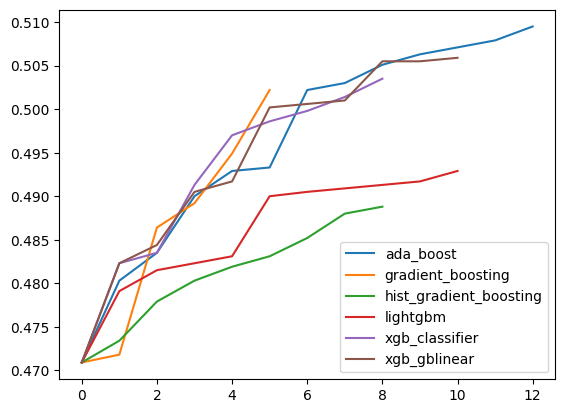

In [23]:
plot_features('../data/output/features/')

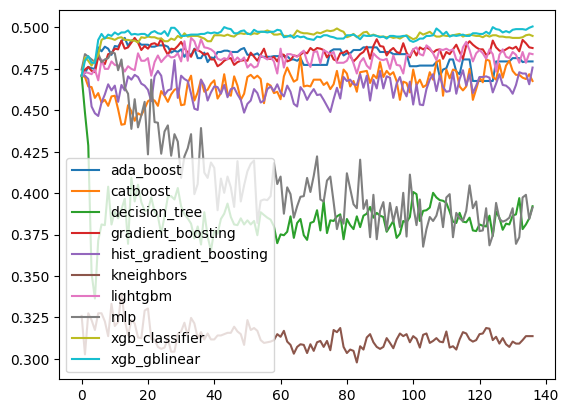

In [21]:
plot_features('../data/output/all_features/')